In [162]:
import numpy
import tensorflow as tf
from tensorflow.keras import activations, optimizers, losses
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
from datasets import load_dataset

dataset = load_dataset("health_fact")

Using custom data configuration default
Reusing dataset health_fact (/Users/braytonhall/.cache/huggingface/datasets/health_fact/default/1.1.0/99503637e4255bd805f84d57031c18fe4dd88298f00299d56c94fc59ed68ec19)


  0%|          | 0/3 [00:00<?, ?it/s]

In [152]:
dataset['train'].info

DatasetInfo(description='PUBHEALTH is a comprehensive dataset for explainable automated fact-checking of\npublic health claims. Each instance in the PUBHEALTH dataset has an associated\nveracity label (true, false, unproven, mixture). Furthermore each instance in the\ndataset has an explanation text field. The explanation is a justification for which\nthe claim has been assigned a particular veracity label.\n\nThe dataset was created to explore fact-checking of difficult to verify claims i.e.,\nthose which require expertise from outside of the journalistics domain, in this case\nbiomedical and public health expertise.\n\nIt was also created in response to the lack of fact-checking datasets which provide\ngold standard natural language explanations for verdicts/labels.\n\nNOTE: There are missing labels in the dataset and we have replaced them with -1.\n', citation='@inproceedings{kotonya-toni-2020-explainable,\n    title = "Explainable Automated Fact-Checking for Public Health Claims",\

In [37]:
MODEL_NAME = 'distilbert-base-uncased'
MAX_LEN = 120

tkzr = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

In [38]:
# df_train = dataset['train'].to_pandas().copy()
# df_valid = dataset['validation'].to_pandas().copy()
# df_test = dataset['test'].to_pandas().copy()

In [39]:
df_train = dataset['train'].to_pandas()
df_valid = dataset['validation'].to_pandas()
df_test = dataset['test'].to_pandas()

In [139]:
df_train.bilabel.value_counts()

1    7637
0    3381
Name: bilabel, dtype: int64

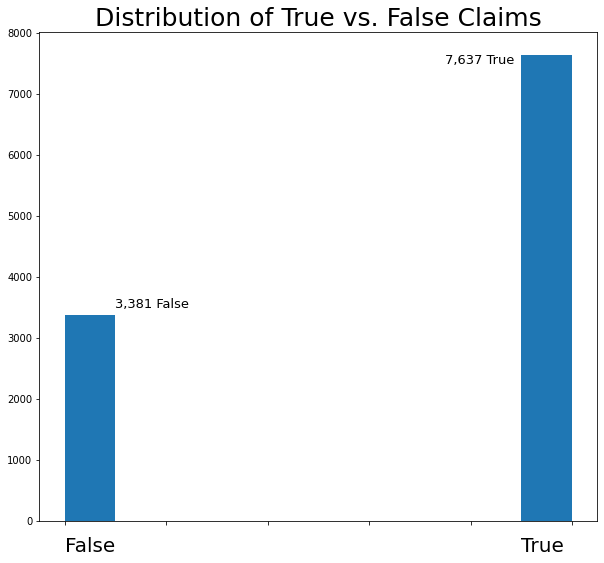

In [159]:
df_train.bilabel.hist(figsize=(10,9))
plt.tick_params(
    axis='x', 
    labelbottom=False)
plt.grid(b=None)
plt.title('Distribution of True vs. False Claims', fontsize=25)
plt.text(0,-500, 'False', fontsize=20)
plt.text(.9,-500, 'True', fontsize=20)
plt.text(.1,3500, '3,381 False', fontsize=13)
plt.text(.75,7500, '7,637 True', fontsize=13)
plt.show()

In [40]:
df_train = df_train[df_train['label'] != -1]
df_test = df_test[df_test['label'] != -1]
df_valid = df_valid[df_valid['label'] != -1]

In [41]:
df_train['bilabel'] = df_train['label'].map({0:0, 1:1, 2:1, 3:1}).values
df_test['bilabel'] = df_test['label'].map({0:0, 1:1, 2:1, 3:1}).values
df_valid['bilabel'] = df_valid['label'].map({0:0, 1:1, 2:1, 3:1}).values

In [42]:
df_train = df_train.append(df_valid)

In [43]:
def construct_encodings(x, tkzr, max_len, trucation=True, padding=True):
    return tkzr(x, max_length=max_len, truncation=trucation, padding=padding)
    


In [60]:
train_encodings = construct_encodings(df_train.claim.tolist(), tkzr, max_len=MAX_LEN)
test_encodings = construct_encodings(df_test.claim.tolist(), tkzr, max_len=MAX_LEN)

In [61]:
y_train = df_train.bilabel.tolist()
y_test = df_test.bilabel.tolist()

In [ ]:
BATCH_SIZE = 2

def construct_tfdataset(encodings, y=None):
    if y:
        return tf.data.Dataset.from_tensor_slices((dict(encodings),y))
    else:
        # this case is used when making predictions on unseen samples after training
        return tf.data.Dataset.from_tensor_slices(dict(encodings))

In [62]:
tfdataset_train = construct_tfdataset(train_encodings, y_train)
tfdataset_train = tfdataset_train.batch(BATCH_SIZE)

In [63]:
tfdataset_test = construct_tfdataset(test_encodings, y_test)
tfdataset_test = tfdataset_test.batch(BATCH_SIZE)

In [47]:
N_EPOCHS = 2


model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME)
optimizer = optimizers.Adam(learning_rate=3e-5)
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

model.fit(tfdataset_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_projector', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_99']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/2
5509/5509 [==============================] - 3482s 631ms/step - loss: 0.4950 - accuracy: 0.7181
Epoch 2/2
5509/5509 [==============================] - 3503s 636ms/step - loss: 0.4209 - accuracy: 0.7742


In [48]:
model.save_pretrained('./model/clf')
with open('./model/info.pkl', 'wb') as f:
    pickle.dump((MODEL_NAME, MAX_LEN), f)

In [49]:
new_model = TFDistilBertForSequenceClassification.from_pretrained('./model/clf')
model_name, max_len = pickle.load(open('./model/info.pkl', 'rb'))

Some layers from the model checkpoint at ./model/clf were not used when initializing TFDistilBertForSequenceClassification: ['dropout_99']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at ./model/clf and are newly initialized: ['dropout_119']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [64]:
tfdataset_test

<BatchDataset shapes: ({input_ids: (None, 82), attention_mask: (None, 82)}, (None,)), types: ({input_ids: tf.int32, attention_mask: tf.int32}, tf.int32)>

In [65]:
preds = model.predict(tfdataset_test).logits

In [66]:
preds

array([[ 0.5942735 , -0.31716093],
       [-2.8978682 ,  2.3464131 ],
       [ 0.5275398 , -0.264208  ],
       ...,
       [ 0.3431798 , -0.11481979],
       [-2.8899317 ,  2.3509235 ],
       [-2.7217176 ,  2.1967022 ]], dtype=float32)

In [67]:
preds_bin = activations.softmax(tf.convert_to_tensor(preds)).numpy()

In [68]:
preds_bin

array([[0.7132936 , 0.28670642],
       [0.00524991, 0.9947501 ],
       [0.6882065 , 0.3117935 ],
       ...,
       [0.6125395 , 0.3874605 ],
       [0.00526783, 0.99473214],
       [0.00725762, 0.9927424 ]], dtype=float32)

In [72]:
predfinal = []
for i in preds_bin:
    if i[0] >= i[1]:
        predfinal.append(0)
    else:
        predfinal.append(1)

In [69]:
actual = df_test.bilabel.values

In [ ]:
tfdataset_test = tfdataset_test.batch(BATCH_SIZE)

In [76]:
# confusion matrix in sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# # actual values
# actual = [1,0,0,1,0,0,1,0,0,1]
# # predicted values
# predicted = [1,0,0,1,0,0,0,1,0,0]

# confusion matrix
matrix = confusion_matrix(actual,predfinal, labels=[0,1])
print('Confusion matrix : \n',matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(actual,predfinal,labels=[0,1]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(actual,predfinal,labels=[0,1])
print('Classification report : \n',matrix)

Confusion matrix : 
 [[252 136]
 [193 652]]
Outcome values : 
 252 136 193 652
Classification report : 
               precision    recall  f1-score   support

           0       0.57      0.65      0.61       388
           1       0.83      0.77      0.80       845

    accuracy                           0.73      1233
   macro avg       0.70      0.71      0.70      1233
weighted avg       0.75      0.73      0.74      1233



In [160]:
# confusion matrix in sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# # actual values
# actual = [1,0,0,1,0,0,1,0,0,1]
# # predicted values
# predicted = [1,0,0,1,0,0,0,1,0,0]

# confusion matrix
matrix = confusion_matrix(actual,predfinal, labels=[0,1])
print('Confusion matrix : \n',matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(actual,predfinal,labels=[0,1]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(actual,predfinal,labels=[0,1])
print('Classification report : \n',matrix)

Confusion matrix : 
 [[252 136]
 [193 652]]
Outcome values : 
 252 136 193 652
Classification report : 
               precision    recall  f1-score   support

           0       0.57      0.65      0.61       388
           1       0.83      0.77      0.80       845

    accuracy                           0.73      1233
   macro avg       0.70      0.71      0.70      1233
weighted avg       0.75      0.73      0.74      1233



In [166]:
confmatrix = confusion_matrix(actual,predfinal, labels=[0,1])

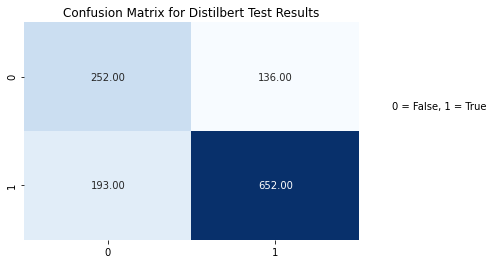

In [191]:
sns.heatmap(confmatrix, annot=True, cmap='Blues', fmt='.2f', cbar = False)
plt.title('Confusion Matrix for Distilbert Test Results')
plt.text(2.2,.8,'0 = False, 1 = True')
plt.show()

In [104]:
df_train[0:10]

,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects,bilabel
0,15661,"""The money the Clinton Foundation took from fr...","April 26, 2015","""Gingrich said the Clinton Foundation """"took m...",Katie Sanders,"""Hillary Clinton is in the political crosshair...",https://www.wsj.com/articles/clinton-foundatio...,0,"Foreign Policy, PunditFact, Newt Gingrich,",0
1,9893,Annual Mammograms May Have More False-Positives,"October 18, 2011",This article reports on the results of a study...,,While the financial costs of screening mammogr...,,1,"Screening,WebMD,women's health",1
2,11358,SBRT Offers Prostate Cancer Patients High Canc...,"September 28, 2016",This news release describes five-year outcomes...,"Mary Chris Jaklevic,Steven J. Atlas, MD, MPH,K...",The news release quotes lead researcher Robert...,https://www.healthnewsreview.org/wp-content/up...,1,"Association/Society news release,Cancer",1
3,10166,"Study: Vaccine for Breast, Ovarian Cancer Has ...","November 8, 2011","While the story does many things well, the ove...",,"The story does discuss costs, but the framing ...",http://clinicaltrials.gov/ct2/results?term=can...,2,"Cancer,WebMD,women's health",1
4,11276,Some appendicitis cases may not require ’emerg...,"September 20, 2010",We really don’t understand why only a handful ...,,"""Although the story didn’t cite the cost of ap...",,2,,1
5,8713,Britain to reveal trial criteria for coronavir...,"April 7, 2020",British regulators will this week reveal appro...,Alistair Smout,Antibody tests show whether whether people hav...,,2,Health News,1
6,9851,Angioplasty through the wrist backed by new study,"August 18, 2008",This is a good piece of reporting about a rece...,,The story did not provide cost estimates for e...,,2,,1
7,2768,U.S. says results encouraging for healthcare d...,"January 30, 2014",The Obama administration on Thursday reported ...,David Morgan,As part of President Barack Obama’s healthcare...,,2,Health News,1
8,2717,Latest trial in J&J talc litigations gets unde...,"January 8, 2019",A California jury on Monday heard opening stat...,Tina Bellon,The lawsuit brought by Terry Leavitt in Alamed...,"uk.reuters.com/companies/IMTP.PA,uk.reuters.co...",2,Health News,1
9,10527,Poor test results for heart drugs,"March 31, 2008","""The story reports no additional cardiovascula...",,"""The story does not note the cost of a typical...",,0,,0


In [90]:
predfinalmic

[0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,


In [91]:
mictest = df_train.claim[0:10]

In [92]:
micenc = construct_encodings(mictest.tolist(), tkzr, max_len=MAX_LEN)

In [93]:
mic_test = construct_tfdataset(micenc)
mic_test = mic_test.batch(BATCH_SIZE)

In [94]:
predsmic = model.predict(mic_test).logits

In [95]:
predsmicbin =  activations.softmax(tf.convert_to_tensor(predsmic)).numpy()

In [96]:
predsmicbin

array([[0.7993933 , 0.20060673],
       [0.11083271, 0.8891673 ],
       [0.39029142, 0.60970855],
       [0.30028698, 0.699713  ],
       [0.13804701, 0.86195296],
       [0.0052646 , 0.9947354 ],
       [0.18013027, 0.81986976],
       [0.005412  , 0.994588  ],
       [0.00519843, 0.99480164],
       [0.35216007, 0.64784   ]], dtype=float32)

In [101]:
predfinalmic = []
for i in predsmicbin:
    if i[0] >= i[1]:
        predfinalmic.append(0)
    else:
        predfinalmic.append(1)

In [102]:
predsmicbin

array([[0.7993933 , 0.20060673],
       [0.11083271, 0.8891673 ],
       [0.39029142, 0.60970855],
       [0.30028698, 0.699713  ],
       [0.13804701, 0.86195296],
       [0.0052646 , 0.9947354 ],
       [0.18013027, 0.81986976],
       [0.005412  , 0.994588  ],
       [0.00519843, 0.99480164],
       [0.35216007, 0.64784   ]], dtype=float32)

In [103]:
predfinalmic

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1]